In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [2]:
from functools import partial
import jax # jax==0.1.67 / jaxlib==0.1.55
from jax import random, grad, jit, vmap, flatten_util, nn
from jax.experimental import optix
from jax.config import config
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2

import imageio
import json
import pickle

rng = jax.random.PRNGKey(42)

If you do not have jax and jaxlib, install -
* pip install --upgrade jax==0.1.77 jaxlib==0.1.64+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

# Dataset loader
There are two dataloader below - ShapeNet and Realistic synthetic (Lego)

You should change `DATA_PATH` and `SPLITS_FILE` to the collect path

# ShapeNet Data

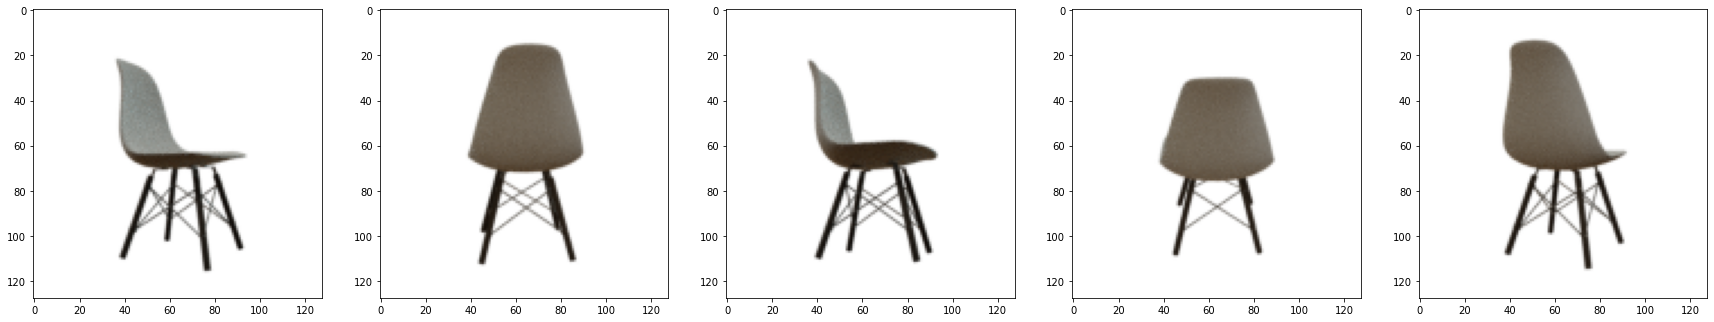

In [3]:
SPLITS_FILE = '/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chair_splits.json' # Update
DATA_PATH = '/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chairs/03001627' # Update

import json
import imageio

def load_train_ex(train_ex_dir, key=None):
    
    with open(os.path.join('/', train_ex_dir, 'transforms.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(train_ex_dir, os.path.basename(frame['file_path']) + '.png')
        imgs.append(imageio.imread(fname))
        poses.append(np.array(frame['transform_matrix']))
    H, W = imgs[0].shape[:2]
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

with open(SPLITS_FILE, "r") as read_file:
    splits = json.load(read_file)

train_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['train'])]
test_exs =[os.path.join(DATA_PATH, d) for d in sorted(splits['test'])]
val_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['val'])]

images, poses, hwf = load_train_ex(train_exs[4], rng)
fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])

# Lego Data

(100, 200, 200, 3)
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[200, 200, DeviceArray(69.44444, dtype=float32)]


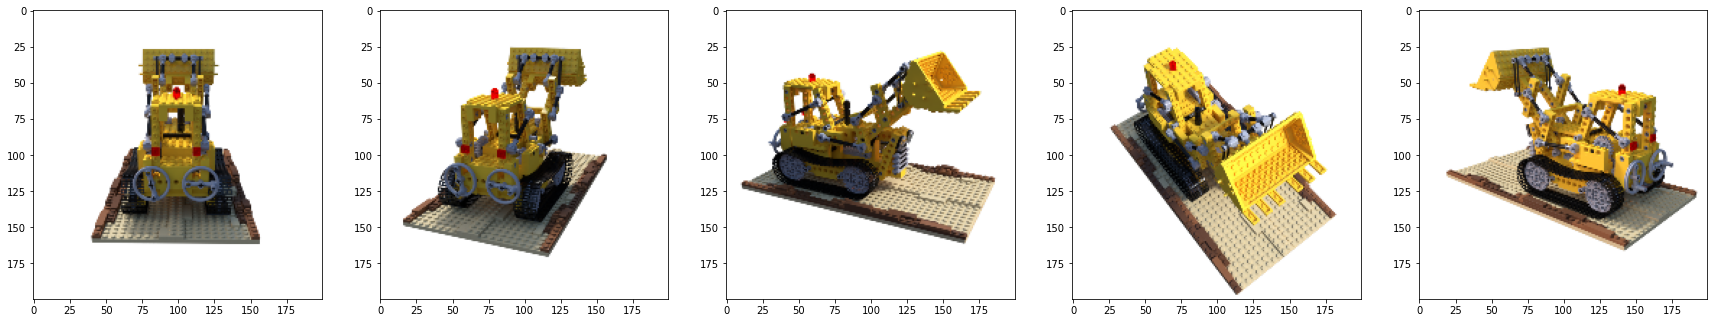

In [3]:
DATA_PATH = '/mnt/disk2/JYChung/dataset/NeRF_Data/nerf_synthetic/lego/' # Update
# Assume that - scene0 scene1 scene2 scene3 scene4 is placed in $DATA_PATH$ folder

import json
import imageio
import cv2

def load_nerf_synthetic(scene_path, type="test", down=4):
    # h,w,f = 800, 800, 1111.11
    with open(os.path.join(DATA_PATH, 'transforms_'+type+'.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    img0 = imageio.imread(os.path.join(scene_path, 'r_0.png')) # to get H, W
    H, W = 800//down,800//down#img0.shape[0]//down, img0.shape[1]//down
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(scene_path, 'r_'+str(idx)+'.png')
        try:
            imgs.append(cv2.resize(imageio.imread(fname),(H,W)))
            poses.append(np.array(frame['transform_matrix']))
        except:
            continue
    focal = .5 * W / np.tan(.5 * camera_angle_x)/down #1111.11/down #
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

num_scene = 5
train_exs =[os.path.join(DATA_PATH, "scene"+str(scene), "train") for scene in range(num_scene)]
# test_exs =[os.path.join(DATA_PATH, "scene"+str(scene), "test") for scene in range(num_scene)]

imgs, poses, hwf = load_nerf_synthetic(scene_path=train_exs[0], type="train", down=4) # scene0, scene1, scene2 ...

fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i])
print(imgs.shape)
print(poses[0])
print(hwf)

# Define NeRF Model and Rendering function

In [4]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(
        c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1))
get_ray_batch = jax.vmap(get_rays, in_axes=[None, None, None, 0], out_axes=1)

In [6]:
def render_rays(rnd_input, model, params, rays, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays
    
    near = 2
    far = 6

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    # print(pts.shape)
    # print(rays_o[...,None,:])
    # viewdirs
    # viewdirs = rays_o/np.linalg.norm(rays_o, axis=1)[0]
    # viewdirs = np.stack((np.arctan2(viewdirs[:,0], viewdirs[:,1]), np.arcsin(viewdirs[:,2])), axis=1)

    # Run network
    # pts_flat = np.reshape(pts, [-1,3])
        
    raw = model.apply(params, pts, rays_o)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e-3], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2)
    acc_map = np.sum(weights, -1)    
    rgb_map = rgb_map + (1.-acc_map[...,None]) # white background 
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, rays, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, rays, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 4, 5, 6))

def render_fn(rnd_input, model, params, rays, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, rays[:,i:i+chunk], rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [106]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 6
        self.use_viewdirs = True
                
    def __call__(self, coords, viewdirs=None):
        coordsh = coords.shape[-2]
        # print("coordsh: ", coords.shape, coordsh)
        coords = np.reshape(coords, [-1,3])
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.repeat(viewdirs[...,None,:], coordsh, axis=-2)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            # print(x.shape, viewdirs.shape)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

# Single Train

* `checkpoint_dir` is for save path, please change.
* Note that, the model above is simplified version of nerf (without view direction / small number of layers)
* That is why lego shows worse result. (if you test with shapeNet dataset, )

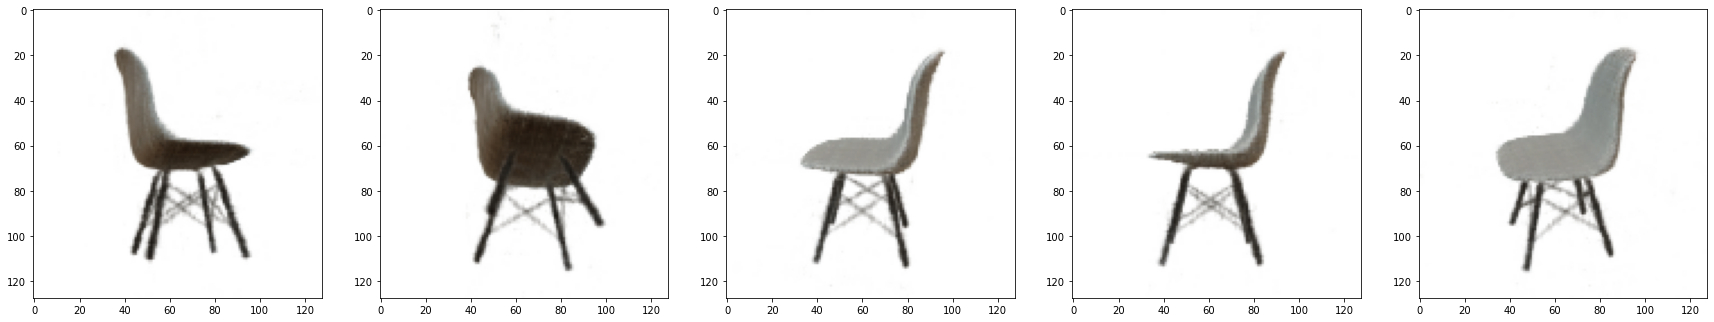

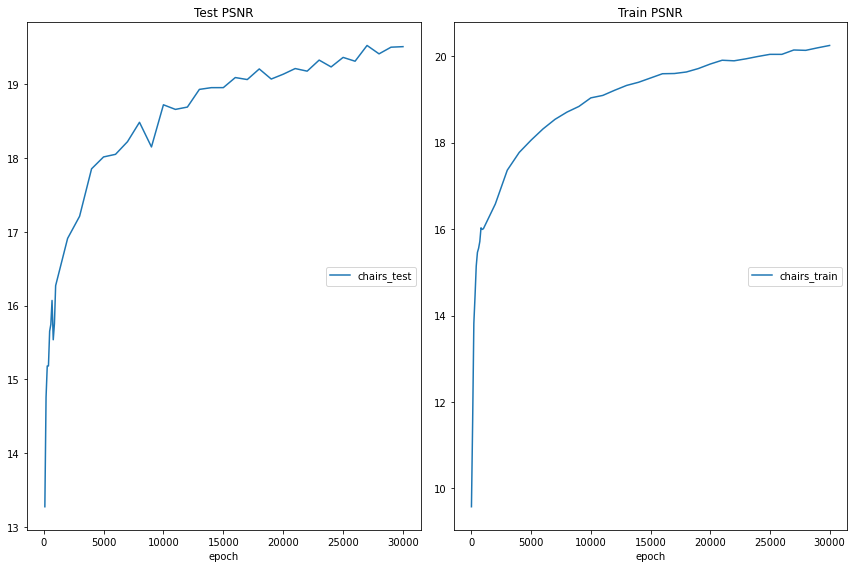

Test PSNR
	chairs_test      	 (min:   13.277, max:   19.523, cur:   19.506)
Train PSNR
	chairs_train     	 (min:    9.577, max:   20.249, cur:   20.249)


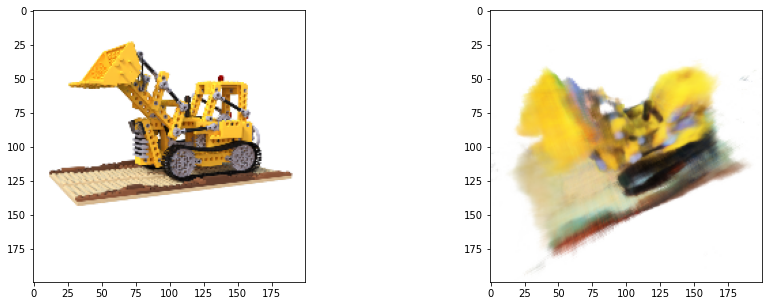

In [107]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

exp_name = 'chairs'
max_iters = 30001
batch_size = 256

inner_update_steps = 1
lr = inner_step_size = 5e-4

# checkpoint_dir = 'checkpoints/checkpoints_singlechair'
checkpoint_dir = 'checkpoints/checkpoints_lego'
os.makedirs(checkpoint_dir, exist_ok=True)

N_samples = 1024

model = hk.without_apply_rng(hk.transform(lambda x, y: Model()(x, y))) #y=None
params = model.init(rng, np.ones((1,3)), np.ones((1,3)))

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

# update inner model network weights with once step of sgd
@jit
def single_step(rng, images, rays, params, idx):
    def sgd(param, update):
        return param - inner_step_size * update

    def loss_fn(params, rng_inputs):
        idx = random.randint(rng_inputs[0], shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]

        g = render_rays(rng_inputs[1], model, params, rays_sub, N_samples, rand=True)
        return mse_fn(g, image_sub)

    rng, *rng_inputs = jax.random.split(rng, 3)
    loss, grad = jax.value_and_grad(loss_fn)(params, rng_inputs)
    params = jax.tree_multimap(sgd, params, grad)
    return rng, params, loss

# update inner model network weights inner_update_steps number of times
def update_network_weights(rng, images, rays, params):
    for _ in range(inner_update_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
    return rng, params, loss

# update meta model weights based on trained inner model weights
def update_model(rng, params, opt_state, images, rays):
    rng, new_params, model_loss = update_network_weights(rng, images, rays, params)

    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss


opt = optix.adam(lr)
opt_state = opt.init(params)

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0
train_psnrs = []
rng = jax.random.PRNGKey(0)

train_size = len(train_exs)
test_psnrs = []

num_test = 5
rng, rng_input = jax.random.split(rng)
# images, poses, hwf = load_train_ex(train_exs[4], rng) # 50 # load_nerf_synthetic
images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[0], type="train", down=4) # scene0, scene1, scene2 ...
train_images, test_images = np.split(images, [images.shape[0]-num_test], axis=0)
train_poses, test_poses = np.split(poses, [images.shape[0]-num_test], axis=0)

for step in tqdm(range(max_iters)):
    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], train_poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, np.reshape(train_images, (-1,3)), rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step != 0 and (step % 1000 == 0 or (step < 1000 and step % 100 == 0)):
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(num_test):
            test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[i])
            test_result = np.clip(render_fn(rng, model, params, test_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_images[i], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))

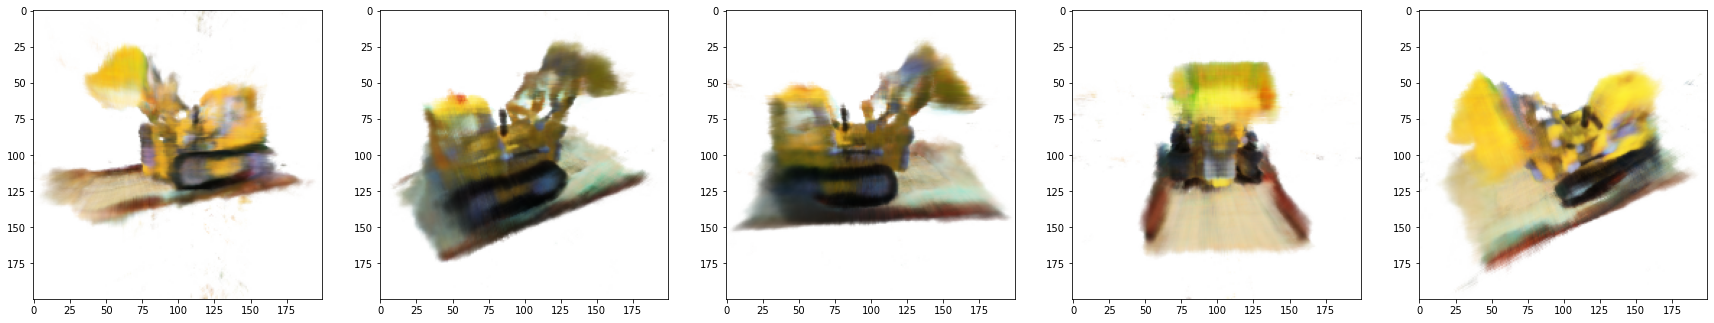

In [115]:
# if step % (max_iters-1) == 0:
fig = plt.figure(figsize=(30, 10))   
for i in range(num_test):
    test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[i])
    test_result = np.clip(render_fn(rng, model, params, test_rays, N_samples, rand=False)[0], 0, 1)
    ax = fig.add_subplot(1, num_test, i+1)
    ax.imshow(test_result)
plt.savefig('legofig'+str(step)+'.png', dpi=300)

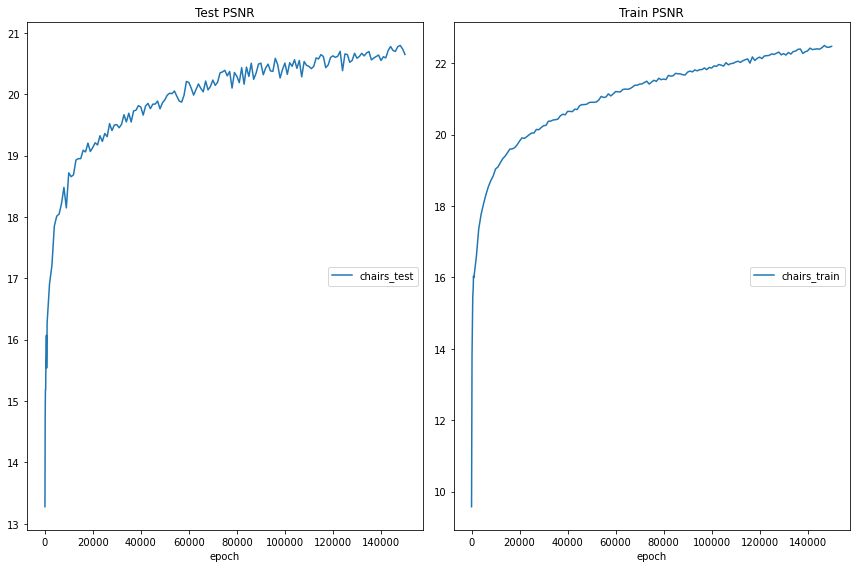

Test PSNR
	chairs_test      	 (min:   13.277, max:   20.796, cur:   20.649)
Train PSNR
	chairs_train     	 (min:    9.577, max:   22.496, cur:   22.471)


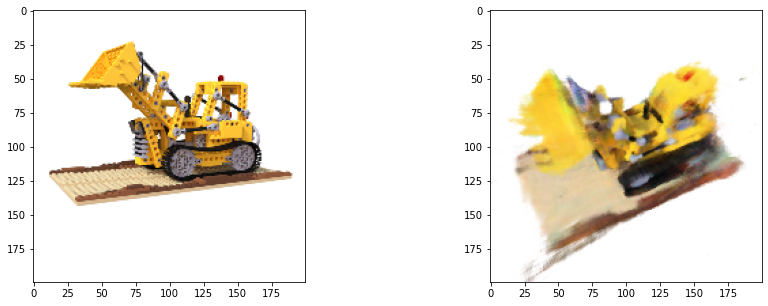

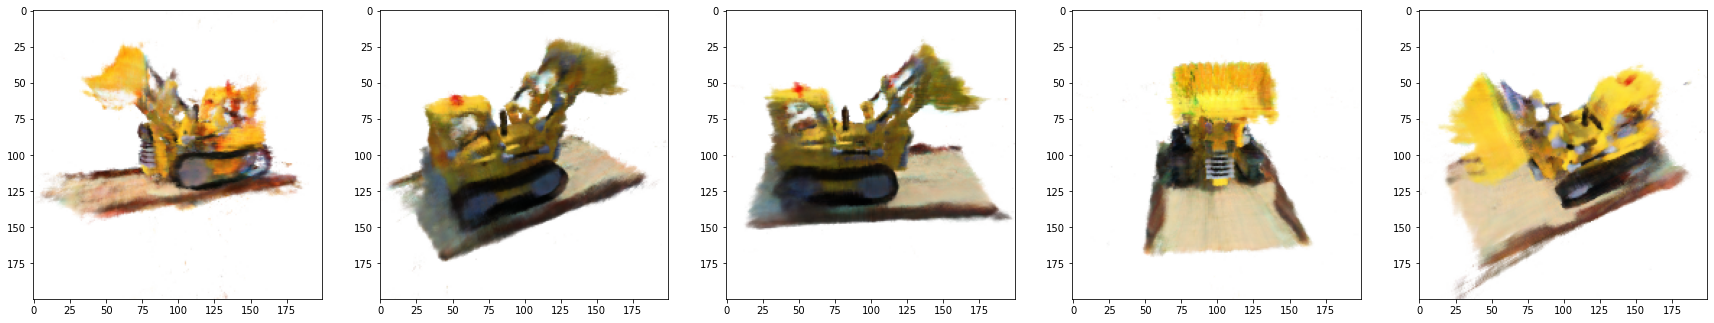

In [116]:
for step in tqdm(range(max_iters+1, 5*max_iters)):
    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], train_poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, np.reshape(train_images, (-1,3)), rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step != 0 and (step % 1000 == 0 or (step < 1000 and step % 100 == 0)):
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(num_test):
            test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[i])
            test_result = np.clip(render_fn(rng, model, params, test_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_images[i], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))
    if step % (max_iters-1) == 0:
        fig = plt.figure(figsize=(30, 10))   
        for i in range(num_test):
            test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[i])
            test_result = np.clip(render_fn(rng, model, params, test_rays, N_samples, rand=False)[0], 0, 1)
            ax = fig.add_subplot(1, num_test, i+1)
            ax.imshow(test_result)
        plt.savefig('legofig'+str(step)+'.png', dpi=300)

In [24]:
rays.shape

(2, 3800000, 3)

* Q1) batching을 크게 가져갈수록 혹은 N_samples를 크게 가져 갈수록, iteration 당 걸리는 시간은 늘어가긴하는데, 빨리 수렴한다는 점에서는 크게 가져가는게 유리한가?
